# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [24]:
# Imports here

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import PIL
from PIL import Image

import helper
import json
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [9]:
# main directory name is '/aipnd-project' and /flowers/train, etc... are all subfolders
# some additonal 'helper' python files are also included in this main directory

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [10]:
# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=72, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=72)
testloader = torch.utils.data.DataLoader(test_data, batch_size=72)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


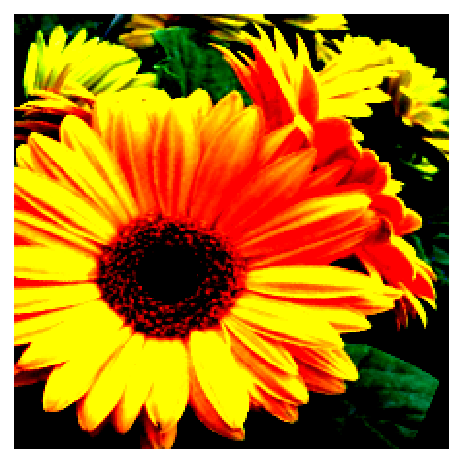

In [11]:
# Sanity check  to see some images -  trainloader or testloader 
# Run this to test your data loader
images, labels = next(iter(trainloader))
helper.imshow(images[0], normalize=False)


In [12]:
# Qi=uick test on correct Images and labels shapes
print(images.shape)
print(labels.shape)


torch.Size([72, 3, 224, 224])
torch.Size([72])


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [13]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [14]:
# Test sucessful load of the Class to Flower names
print(type(cat_to_name))
print(cat_to_name['1'])
print(cat_to_name['102'])
print(len((cat_to_name)))

<class 'dict'>
pink primrose
blackberry lily
102


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [15]:
# TODO: Build and train your network- I will start with start with base vgg16 model
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Next - we need to Freeze parameters so we don't backprop through them - for base sequential features and 
# Redefine the new feed forward classifier with correct inut and output tensor shapes
# From base vgg16 we can see input to classifier is 25088 and we know we want 102 output nodes for all flowers types
for param in model.parameters():
    param.requires_grad = False


model.classifier = nn.Sequential(nn.Linear(25088, 612),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(612, 102),
                                 nn.LogSoftmax(dim=1))
#now check model has been changed
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
# I built this notebook on my local machine - so I also enabled GPU processing using my NVIDIA Quadropro 1000 on my laptop
# I used this web page: "Towards Data Science" as guidance - and it worked great
### https://towardsdatascience.com/python-environment-setup-for-deep-learning-on-windows-10-c373786e36d1
# This code just sets processing device to 'cuda' and then checks to make sure it is set
# then set model to run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device);
#check device being used
print(device)

cuda


In [19]:
#So now I can start the  & Validation runs - using respective dataset / dataloaders
#set the loss function 
criterion = nn.NLLLoss()

# And backprop optimizer- but only train/ update the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [20]:
# execute training runs- adjusted to  two epochs - as I saw increased accuracy over two versus one  
# Outputs will show loss reductions in both train and validate -  and increasing accuracy - in batches of 5 train/one validate
epochs = 2
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        images, labels = images.to(device), labels.to(device)
        
        #zero out gradients
        optimizer.zero_grad()
        
        #get forward pass probabilities, calc the loss and backprop to update weights 
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # this check sees we hit 5 steps and then does validate check and printout of progress
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            #set model to 'eval' as we don't want to update weights
            model.eval()
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)
                    logps = model(images)
                    batch_loss = criterion(logps, labels)
                    
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validate loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validate accuracy %: {100 *(accuracy/len(validloader)):.3f}")
            running_loss = 0
            #reset model back to training
            model.train()

Epoch 1/2.. Train loss: 12.374.. Validate loss: 6.752.. Validate accuracy %: 7.639
Epoch 1/2.. Train loss: 5.555.. Validate loss: 3.954.. Validate accuracy %: 17.023
Epoch 1/2.. Train loss: 4.161.. Validate loss: 3.697.. Validate accuracy %: 17.085
Epoch 1/2.. Train loss: 3.642.. Validate loss: 3.292.. Validate accuracy %: 24.742
Epoch 1/2.. Train loss: 3.541.. Validate loss: 3.005.. Validate accuracy %: 31.962
Epoch 1/2.. Train loss: 3.223.. Validate loss: 2.574.. Validate accuracy %: 39.049
Epoch 1/2.. Train loss: 2.910.. Validate loss: 2.429.. Validate accuracy %: 41.186
Epoch 1/2.. Train loss: 2.842.. Validate loss: 2.261.. Validate accuracy %: 44.685
Epoch 1/2.. Train loss: 2.818.. Validate loss: 2.023.. Validate accuracy %: 47.650
Epoch 1/2.. Train loss: 2.541.. Validate loss: 1.876.. Validate accuracy %: 50.739
Epoch 1/2.. Train loss: 2.549.. Validate loss: 1.848.. Validate accuracy %: 50.828
Epoch 1/2.. Train loss: 2.362.. Validate loss: 1.542.. Validate accuracy %: 58.796
Epoc

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

## CG NOTES ##
The training results show that at least with the training and validate data the accuracy got to almost 71% and in some preliminary runs got aas high as 75%.
A much cooler point to note - with cuda enabled - it processed this on my laptop (Lenovo P52 with one GPU- with a GPU max of 4GB memory) in about 19 minutes

In [21]:
# TODO: Do a final validation on the TEST set of data 
# first- we can set the model to run on  cpu-- don't really need gpu for this
device = torch.device("cpu")

model.to(device);
#check device being used
print(device)

cpu


## CG NOTES ##
Next we maller TEST run on the TESTLOADER data, using the 'model' as currently trained - i.e. with all better/ perfected weights. This will enable us to calculate a  final Test Accuracy with data not yet seen by the model training 

In [25]:
# RUN ON testloader data
start = time.time()
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logps = model(images)
        test_loss = criterion(logps, labels)

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Accuracy: {accuracy/len(testloader)* 100:.3f} %")
print (f"Device = {device}; Total Test Time: {(time.time() - start)/60:.3f} minutes")

Test Accuracy: 69.946 %
Device = cpu; Total Training Time: 2.859 minutes


## CG Notes ##
Final test shows accuracy of just about 70% and the Test ran in approx less than 3 mins - using device = 'cpu'

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [26]:
# TODO: Save the checkpoint :
#First create a dictionary to add all the things want to save
# most importantly the model's state_dict and the classifier
model.class_to_idx = train_data.class_to_idx

checkpoint = {'classifier': model.classifier,
              'class_to_idx': model.class_to_idx,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'epochs': epochs}



In [28]:
# And  then we can SAVE the checkpoint to a file 
torch.save(checkpoint, 'mymodelcheckpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [29]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    #load in checkpoint data to dictionary
    checkpoint = torch.load(filepath)
    #set our model type
    model = models.vgg16(pretrained=True)
    #freeze params for the features (sequential) layers
    for param in model.parameters():
        param.requires_grad = False
    
    #Now load up other custom things from saved model 
    
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['model_state_dict'])

    #for other items in the checkpoint- like epochs and optimizer state
    #these can be addressed once model returned 
    
    return model

In [30]:
# Now we can test the loaded Checkpoint function, and also examine the model it returns, plus confirm that 
# any of the custom things ew added are saved - like the custom classifier
# then we can compare this definition with one done earlier - and if we did well - it will be same (which it is)
model_test = load_checkpoint('mymodelcheckpoint.pth')
model_test

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [31]:
# And for a Final test - we can run our TEST DASTA SET validation again - but with newly loaded 'model_test'
# using the 'model_test' as loaded
# and then  compute Test Accuracy and compare to earlier run with orginal 'model'
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        logps = model_test(images)
        test_loss = criterion(logps, labels)

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Accuracy: {accuracy/len(testloader)* 100:.3f} %")

Test Accuracy: 69.946 %


## CG Notes ##
And we can see the 'model_test' returns the same accuracy prediction as the original 'model'
We would of course also want to validate optimizer state dictionary and epochs - other things ew saved - are also updated, conguent to when we finished /saved trained model state.

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [32]:
def process_image(imagefile):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Image  transforms
    infer_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    img_pil = Image.open(imagefile)
    img_tensor = infer_transform(img_pil)
    return img_tensor
 


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [33]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

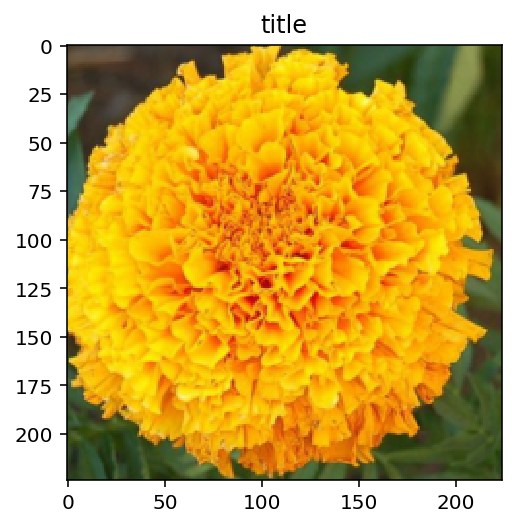

In [34]:
imshow(process_image('flowers/test/47/image_04966.jpg'),None,'title')

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [44]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # No need for GPU 
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();
    
    #this requires some reshaping to get  our needed tensor shape of [1,3,224,224]
    tensor_image = F.interpolate((process_image(image_path).unsqueeze(0)),scale_factor=1).to('cpu')
    #then we take to correct device - in this case 'cpu'
    #tensor_image.to("cpu")

    # TODO: Calculate the class probabilities (softmax) for img
    ps = torch.exp(model(tensor_image))
    top_p, top_index = ps.topk(topk, dim=1)
    
    #We want to return four (4) return vales if possible
    # 1 - top probabilities
    # 2 - the top associated model result indexes
    # 3 - the actual Image Class codes - that map to the Indexes
    # 4 - the Image Names  - if these are provided in a json file on the CLI aruments 
    
    # flatten the tensors first
    top_p_flat = [element.item() for element in top_p.flatten()]
    top_index_flat = [element.item() for element in top_index.flatten()]
    
    # also need the dictionary of indexes -to- image file class codes 
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    #Then check for a cat_to_json file
    catfile = True if cat_to_name else False
    
    #Now we need a list of class_ids
    class_ids = list()
    for idx in top_index_flat:
        class_ids.append(idx_to_class[idx])
    
    #now want to build the images names if a cat_to_names file was provided
    top_classes = {}
    if catfile:
        with open("cat_to_name.json", 'r') as f:
            catnames = json.load(f)
        for clsstr in class_ids:
            top_classes.update({clsstr: catnames[str(clsstr)]})
    #round probabilities
    
    #returning the top probs and indexes as Lists -  as described in instructions, and Class List + flowers as a dictionary 
    return top_p.squeeze().tolist(), top_index_flat, class_ids, top_classes

In [63]:
probs, indexes, classes, flowerlist = predict('flowers/test/44/image_01515.jpg', model)
print ("Top Probabilities: ", ["{:.2%}".format(x) for x in probs])
print('Top Model Indexes:', indexes)
print('Top Flower Class Ids:', classes)
print('Top Class Ids to Flower Names:',flowerlist)

Top Probabilities:  ['99.57%', '0.08%', '0.08%', '0.07%', '0.07%']
Top Model Indexes: [41, 72, 83, 75, 97]
Top Flower Class Ids: ['44', '72', '82', '75', '95']
Top Class Ids to Flower Names: {'44': 'poinsettia', '72': 'azalea', '82': 'clematis', '75': 'thorn apple', '95': 'bougainvillea'}


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [50]:
# TODO: Display an image along with the top 5 classes
# 'Borrowed' some bist from the 'helper' python program that was provided in class materials
# first creating the view proedictions function

def view_predict(img, probs, classlist, flwrlist):
    ''' Function for viewing an image and it's predicted classes.
    '''
    truetype = img.split('/')[-2] 
    imshow(process_image(img), None, flwrlist[truetype])
    
    fig, (ax1) = plt.subplots(figsize=(6,9), ncols=1)
    #using imshow
    #ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    
    ax1.barh(np.arange(len(probs)), probs)
    ax1.set_aspect(0.1)
    ax1.set_yticks(np.arange(len(classlist)))
    flowerlabels = []
    for item in classlist:
        flowerlabels.append(flwrlist[item])
                   
    ax1.set_yticklabels(flowerlabels, size='small');
    ax1.set_title('Class Probability')
    ax1.set_xlim(0, 1.1)


    plt.tight_layout()


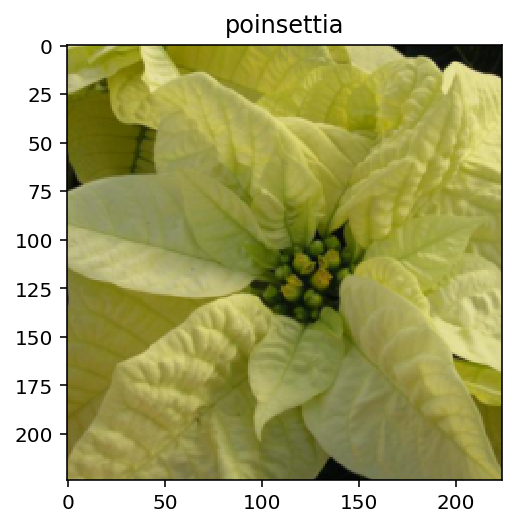

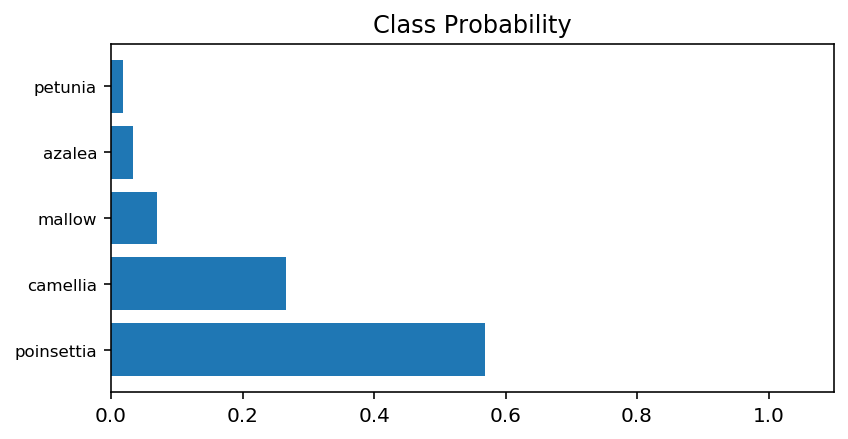

In [65]:
img = 'flowers/test/44/image_01560.jpg'
probs, indexes, classes, flowerlist = predict(img, model)
view_predict(img, probs, classes, flowerlist)

In [66]:
!!jupyter nbconvert "Image Classifier Project.ipynb"

['[NbConvertApp] Converting notebook Image Classifier Project.ipynb to html',
 '[NbConvertApp] Writing 839944 bytes to Image Classifier Project.html']